1. Importing Dependencies

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img
from tensorflow.python.client import device_lib
from keras.utils.vis_utils import model_to_dot

In [3]:
from IPython.display import SVG
from PIL import Image
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


tf.test.gpu_device_name()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10988955340951321346
 xla_global_id: -1]

Sample Images

(243, 286)


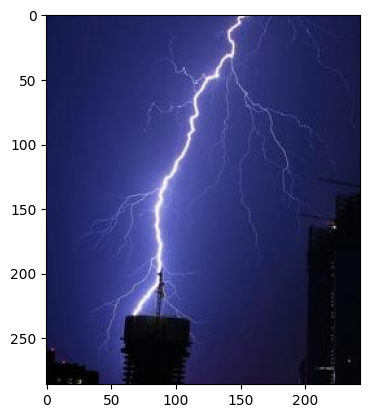

In [3]:
# lightning
img = Image.open("M:/Minor Project sem 5/dataset/training/lightning/1845.jpg")
print(img.size)
plt.imshow(img)

(538, 391)


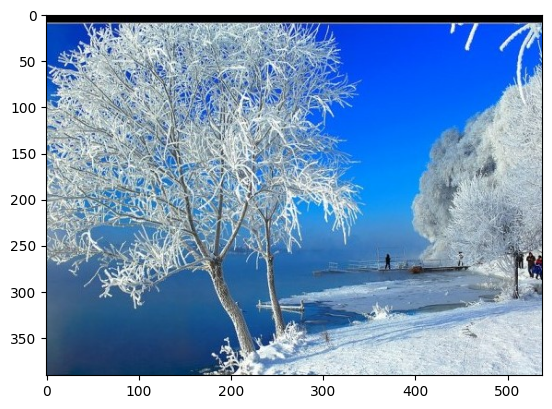

In [4]:
#cloudy
img = Image.open("M:/Minor Project sem 5/dataset/training/rime/4933.jpg")
print(img.size)
plt.imshow(img)

3. Image Processing and Data Augmentation

In [4]:
!mkdir preview
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img("M:/Minor Project sem 5/dataset/training/rime/4949.jpg")  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='rain', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

A subdirectory or file preview already exists.


In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 150

# this is the augmentation configuration we will use just for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only for rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only for rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        "M:/Minor Project sem 5/dataset/training",  # this is the target directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 150x150
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        "M:/Minor Project sem 5/dataset/validation", #this is the validation directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

# this is a similar generator, for test data
test_generator = validation_datagen.flow_from_directory(
        "M:/Minor Project sem 5/dataset/test", #this is the validation directory
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical')



Found 4608 images belonging to 11 classes.
Found 1126 images belonging to 11 classes.
Found 1128 images belonging to 11 classes.


4. Model Implementation

In [7]:
# Model 1 Architecture

keras.backend.clear_session()

input_layer = keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Convolutional Layers
conv_layer = keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
conv_layer = keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2, 2))(conv_layer)

# Fully connected layers
flatten = keras.layers.Flatten()(pooling_layer)
dense = keras.layers.Dense(200, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.5)(flatten)

classifier = keras.layers.Dense(11, activation="softmax")(dropout)   # since we have 11 classes

model = keras.Model(inputs=input_layer, outputs=classifier)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics="accuracy")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 16)      4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dropout (Dropout)           (None, 90000)             0         
                                                             

Visualization of the model

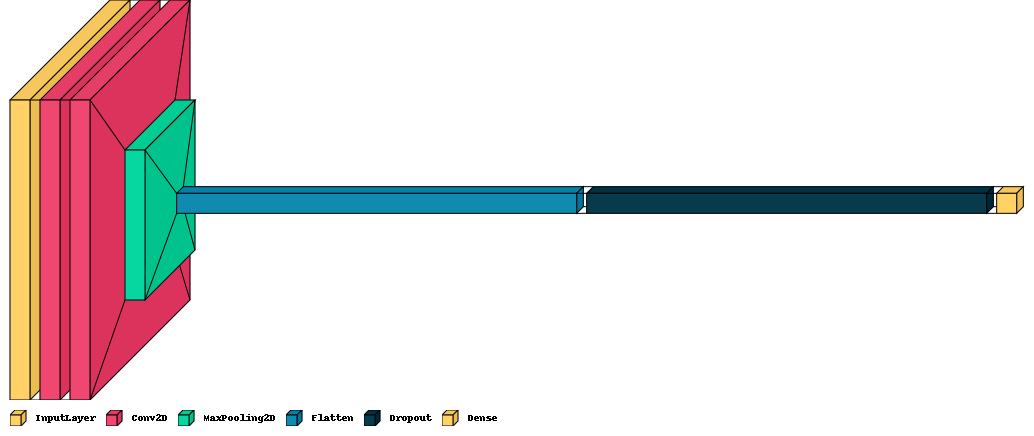

In [8]:
%pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, legend=True,scale_xy=2)

Model 2 Architecture

In [9]:
keras.backend.clear_session()

input_layer = keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Convolution layers
conv_layer = keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
conv_layer = keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2, 2))(conv_layer)

conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(pooling_layer)
conv_layer = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)

# fully connected layer
flatten = keras.layers.Flatten()(pooling_layer)
dense = keras.layers.Dense(200, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.5)(dense)
dense = keras.layers.Dense(100, activation="relu")(dropout)
dropout = keras.layers.Dropout(0.2)(dense)

classifier = keras.layers.Dense(11, activation="softmax")(dropout)

model2 = keras.Model(inputs = input_layer, outputs = classifier)
opt = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        36928     
                                                             

Visualizing the second model

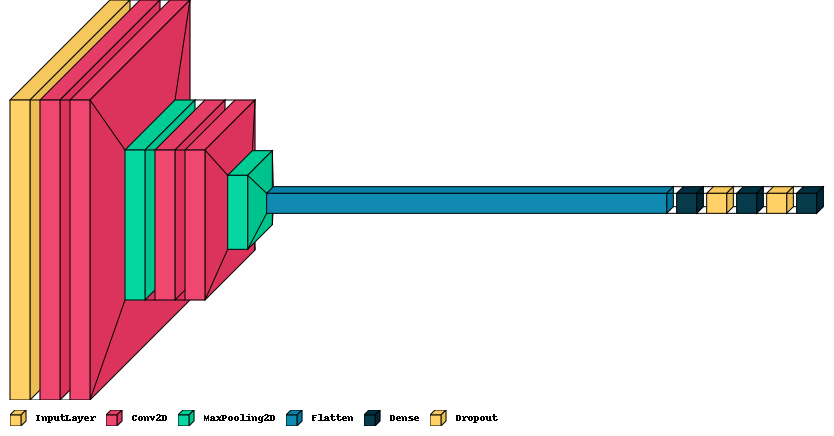

In [10]:
visualkeras.layered_view(model2).show() # display using your system viewer
visualkeras.layered_view(model2, legend=True,scale_xy=2)

5. Training the model

In [11]:
history1 = model.fit(train_generator,validation_data=validation_generator, epochs=20)

Epoch 1/20
144/144 [==============================] - 151s 1s/step - loss: 1.5569 - accuracy: 0.4937 - val_loss: 1.5642 - val_accuracy: 0.5178
Epoch 2/20
144/144 [==============================] - 115s 794ms/step - loss: 1.1602 - accuracy: 0.6181 - val_loss: 1.2342 - val_accuracy: 0.5924
Epoch 3/20
144/144 [==============================] - 109s 756ms/step - loss: 1.0822 - accuracy: 0.6328 - val_loss: 1.2463 - val_accuracy: 0.5808
Epoch 4/20
144/144 [==============================] - 111s 768ms/step - loss: 1.0651 - accuracy: 0.6415 - val_loss: 1.2532 - val_accuracy: 0.5728
Epoch 5/20
144/144 [==============================] - 131s 912ms/step - loss: 1.0382 - accuracy: 0.6534 - val_loss: 1.1251 - val_accuracy: 0.6039
Epoch 6/20
144/144 [==============================] - 135s 939ms/step - loss: 1.0117 - accuracy: 0.6671 - val_loss: 1.2828 - val_accuracy: 0.5782
Epoch 7/20
144/144 [==============================] - 107s 744ms/step - loss: 0.9812 - accuracy: 0.6660 - val_loss: 1.0824 - va

In [12]:
history2 = model2.fit(train_generator,validation_data=validation_generator, epochs=20)

Epoch 1/20
144/144 [==============================] - 264s 2s/step - loss: 2.0467 - accuracy: 0.3190 - val_loss: 1.7822 - val_accuracy: 0.3917
Epoch 2/20
144/144 [==============================] - 297s 2s/step - loss: 1.6296 - accuracy: 0.4787 - val_loss: 1.5408 - val_accuracy: 0.4583
Epoch 3/20
144/144 [==============================] - 301s 2s/step - loss: 1.4168 - accuracy: 0.5473 - val_loss: 1.2554 - val_accuracy: 0.5400
Epoch 4/20
 50/144 [=========>....................] - ETA: 2:53 - loss: 1.3220 - accuracy: 0.5663

KeyboardInterrupt: 

6. Calculating loss

In [ ]:
import matplotlib.pyplot as plt
def plot_curves(history):
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Error')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.legend(['Training', 'Validation'])

  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.legend(['Training', 'Validation'], loc='lower right');

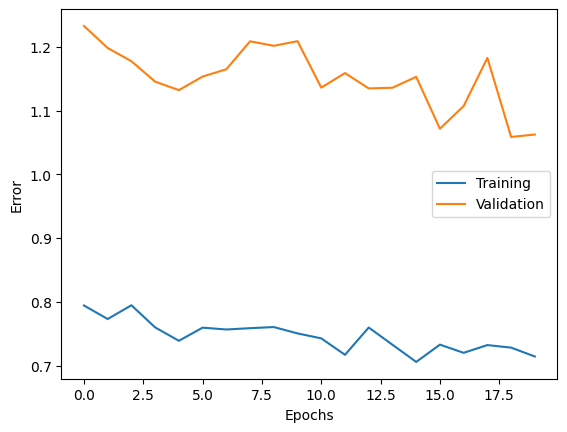

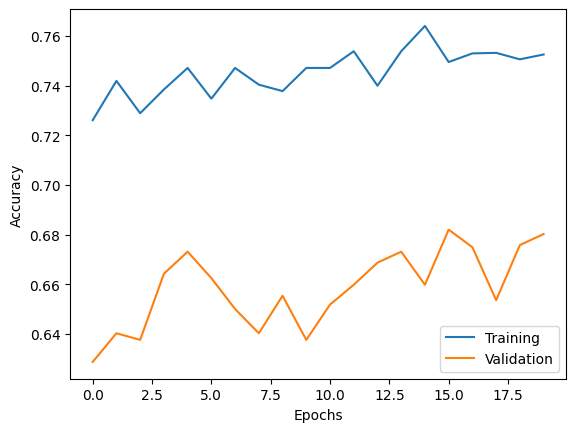

In [ ]:
plot_curves(history1.history)

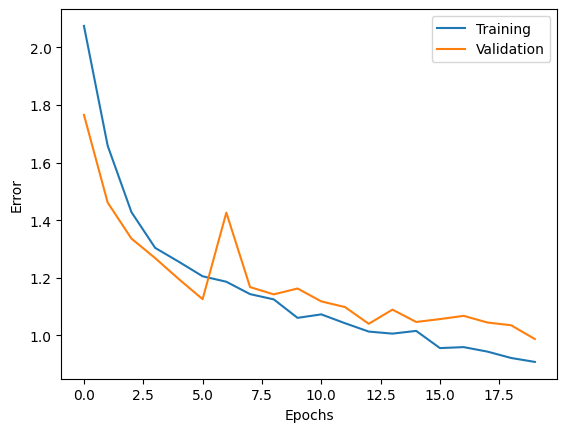

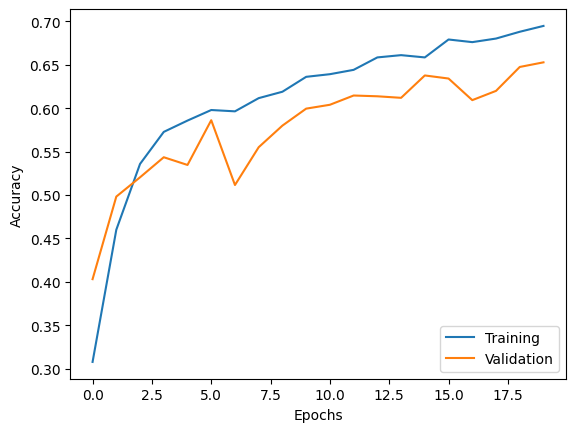

In [ ]:
plot_curves(history2.history)

7. Preliminar Scores (Train & Validation)

In [ ]:
# model 1 score
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

scores_tr = model.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

144/144 [==============================] - 40s 274ms/step - loss: 0.6347 - accuracy: 0.7856
Train loss    : 0.6347250938415527
Train accuracy: 0.7855902910232544
36/36 [==============================] - 5s 138ms/step - loss: 1.0626 - accuracy: 0.6803
Val loss    : 1.0626490116119385
Val accuracy: 0.6802842020988464
36/36 [==============================] - 11s 306ms/step - loss: 0.9813 - accuracy: 0.6888
Test loss    : 0.9813287854194641
Test accuracy: 0.688829779624939


In [ ]:
# model 2 scores

scores_tr = model2.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])

scores_val = model2.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])

scores_tr = model2.evaluate(test_generator)
print('Test loss    :', scores_tr[0])
print('Test accuracy:', scores_tr[1])

144/144 [==============================] - 50s 346ms/step - loss: 0.7955 - accuracy: 0.7272
Train loss    : 0.7954682111740112
Train accuracy: 0.7272135615348816
36/36 [==============================] - 8s 218ms/step - loss: 0.9872 - accuracy: 0.6528
Val loss    : 0.9872104525566101
Val accuracy: 0.6527531147003174
36/36 [==============================] - 9s 234ms/step - loss: 0.9890 - accuracy: 0.6525
Test loss    : 0.98903489112854
Test accuracy: 0.652482271194458


8. Transfer Learning models :)))

VGG16

In [13]:
# VGG16
from keras.applications import VGG16
vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
print(vgg16.summary())


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
keras.backend.clear_session() #clear model numbers

for layer in vgg16.layers:
    layer.trainable = False
    
model_t = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg16,
        # here is our custom prediction layer (same as before)
        keras.layers.Flatten(),    
        keras.layers.Dense(512, activation="relu"),           
        keras.layers.Dropout(0.5),                 
        keras.layers.Dense(256, activation="relu"),           
        keras.layers.Dense(11, activation="softmax")    
    ])

model_t.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_t.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 11)                2827      
                                                                 
Total params: 19,043,659
Trainable params: 4,328,971
Non

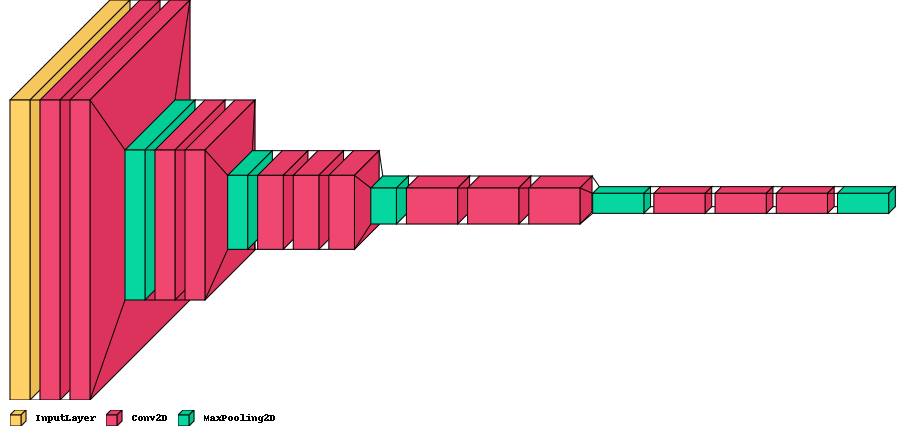

In [ ]:
visualkeras.layered_view(vgg16).show() # display vgg16 model architecture
visualkeras.layered_view(vgg16, legend=True,scale_xy=2)

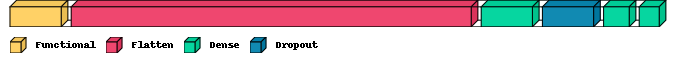

In [ ]:
# viewing the final model based on VGG16
visualkeras.layered_view(model_t).show()
visualkeras.layered_view(model_t, legend=True,scale_xy=2)

In [ ]:
# training the model
history3 = model_t.fit(train_generator,validation_data=validation_generator, epochs=20)

Epoch 1/20
144/144 [==============================] - 237s 2s/step - loss: 1.2828 - accuracy: 0.5577 - val_loss: 1.0741 - val_accuracy: 0.6252
Epoch 2/20
144/144 [==============================] - 240s 2s/step - loss: 1.0480 - accuracy: 0.6335 - val_loss: 0.8656 - val_accuracy: 0.6963
Epoch 3/20
144/144 [==============================] - 240s 2s/step - loss: 0.9469 - accuracy: 0.6630 - val_loss: 0.7941 - val_accuracy: 0.7202
Epoch 4/20
144/144 [==============================] - 267s 2s/step - loss: 0.8874 - accuracy: 0.6851 - val_loss: 0.8282 - val_accuracy: 0.6901
Epoch 5/20
144/144 [==============================] - 265s 2s/step - loss: 0.8717 - accuracy: 0.6873 - val_loss: 0.7964 - val_accuracy: 0.7167
Epoch 6/20
144/144 [==============================] - 241s 2s/step - loss: 0.8594 - accuracy: 0.6984 - val_loss: 0.7699 - val_accuracy: 0.7336
Epoch 7/20
144/144 [==============================] - 239s 2s/step - loss: 0.8098 - accuracy: 0.7088 - val_loss: 0.7384 - val_accuracy: 0.7504

InceptionV3

In [15]:
# InceptionV3
from keras.applications import InceptionV3
inception = InceptionV3(weights="imagenet",
                        include_top=False,
                        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
print(inception.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [19]:
keras.backend.clear_session() #clear model numbers

for layer in inception.layers:
    layer.trainable = False
    
model_inc = tf.keras.models.Sequential([
        # our inception_base model added as a layer
        inception,
        # here is our custom prediction layer (same as before)
        keras.layers.Flatten(),    
        keras.layers.Dense(512, activation="relu"),           
        keras.layers.Dropout(0.5),                 
        keras.layers.Dense(256, activation="relu"),           
        keras.layers.Dense(11, activation="softmax")    
    ])

model_inc.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_inc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 512)               9437696   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 11)                2827      
                                                                 
Total params: 31,374,635
Trainable params: 9,571,851
Non

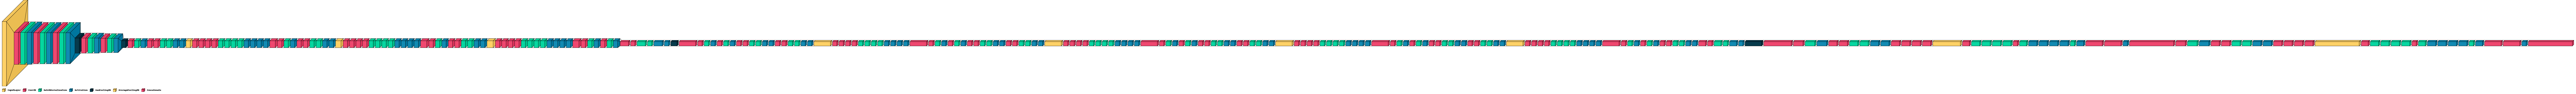

In [17]:
visualkeras.layered_view(inception).show() # display vgg16 model architecture
visualkeras.layered_view(inception, legend=True,scale_xy=2)

In [ ]:
# training the model
history4 = model_inc.fit(train_generator,validation_data=validation_generator, epochs=20)

In [18]:
from keras.applications import DenseNet201
densenet = DenseNet201(weights="imagenet",
                       include_top=False,
                       input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
print(densenet.summary())

74836368/74836368 [==============================] - 115s 2us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNorma

In [20]:
keras.backend.clear_session() #clear model numbers

for layer in densenet.layers:
    layer.trainable = False
    
model_dense = tf.keras.models.Sequential([
        # our densenet_base model added as a layer
        densenet,
        # here is our custom prediction layer (same as before)
        keras.layers.Flatten(),    
        keras.layers.Dense(512, activation="relu"),           
        keras.layers.Dropout(0.5),                 
        keras.layers.Dense(256, activation="relu"),           
        keras.layers.Dense(11, activation="softmax")    
    ])

model_dense.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 4, 4, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 512)               15729152  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 11)                2827      
                                                                 
Total params: 34,185,291
Trainable params: 15,863,307
No

In [ ]:
visualkeras.layered_view(densenet).show() # display vgg16 model architecture
visualkeras.layered_view(densenet, legend=True,scale_xy=2)

In [ ]:
# training the model
history5 = model_dense.fit(train_generator,validation_data=validation_generator, epochs=20)

In [21]:
from keras.applications import ResNet152V2
resnet = ResNet152V2(weights="imagenet",
                     include_top=False,
                     input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
print(resnet.summary())

 73097216/234545216 [========>.....................] - ETA: 18:13

In [ ]:
keras.backend.clear_session() #clear model numbers

for layer in resnet.layers:
    layer.trainable = False
    
model_res = tf.keras.models.Sequential([
        # ourresnet_base model added as a layer
        resnet,
        # here is our custom prediction layer (same as before)
        keras.layers.Flatten(),    
        keras.layers.Dense(512, activation="relu"),           
        keras.layers.Dropout(0.5),                 
        keras.layers.Dense(256, activation="relu"),           
        keras.layers.Dense(11, activation="softmax")    
    ])

model_res.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_res.summary()

In [ ]:
visualkeras.layered_view(resnet).show() # display vgg16 model architecture
visualkeras.layered_view(resnet, legend=True,scale_xy=2)

In [ ]:
# training the model
history6 = model_res.fit(train_generator,validation_data=validation_generator, epochs=20)

In [6]:
from keras.applications import EfficientNetB6
effnet = EfficientNetB6(weights="imagenet",
                     include_top=False,
                     input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
print(effnet.summary())

165234480/165234480 [==============================] - 137s 1us/step
Model: "efficientnetb6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Re

In [8]:
keras.backend.clear_session() #clear model numbers

for layer in effnet.layers:
    layer.trainable = False
    
model_eff = tf.keras.models.Sequential([
        # our efficientnetB6_base model added as a layer
        effnet,
        # here is our custom prediction layer (same as before)
        keras.layers.Flatten(),    
        keras.layers.Dense(512, activation="relu"),           
        keras.layers.Dropout(0.5),                 
        keras.layers.Dense(256, activation="relu"),           
        keras.layers.Dense(11, activation="softmax")    
    ])

model_eff.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_eff.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb6 (Functional)  (None, 5, 5, 2304)       40960143  
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 512)               29491712  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 11)                2827      
                                                                 
Total params: 70,586,010
Trainable params: 29,625,867
No

Note: you may need to restart the kernel to use updated packages.


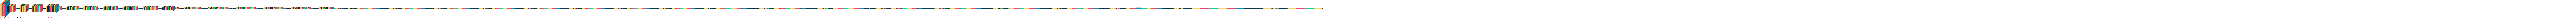

In [12]:
%pip install visualkeras
import visualkeras

visualkeras.layered_view(effnet).show() # display efficientnet model architecture
visualkeras.layered_view(effnet, legend=True,scale_xy=2)

In [ ]:
# training the model
history7 = model_eff.fit(train_generator,validation_data=validation_generator, epochs=20)